# ECG Pre-Processing

**This note book demonstrates the following pre-processing techniques on ECG signals:**
 * Denoising
 * Baseline Fitting
 * R-Peak Detection 
 

In [1]:
%reset

# [0] Global

In [2]:
import datetime
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.signal import medfilt
import pywt # use pip install PyWavelets
from pywt import wavedec
# >---------------------------------------------------------------------

# >------ parent db directory ------------------------------------------
DATASET_DIR = 'sample'
print('DATASET DIR ::',DATASET_DIR)

# >------ global variables  ------------------------------------------
g_DATA = '.mat'
g_HEAD = '.hea'
g_leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6' ]
BASIC_SRATE = 500 #Hz
print('Basic sampling rate(Hz):',BASIC_SRATE)

DATASET DIR :: sample
Basic sampling rate(Hz): 500


# [*] Build record list

* **one time call to build and export the record list**

In [3]:
rec_list = os.listdir(DATASET_DIR)
rec_count = 0 
rec_count_expected = int(len(rec_list)/2)
rec_name_sep = ','
rec_file = open('RECORDS.csv','w')
rec_file.write(str(rec_count_expected))
for f in rec_list:
    if f.endswith(g_HEAD):
        rec_name = f[0:-4]
        rec_file.write(rec_name_sep+rec_name) #<---- use skiprows=1 in np.loadtxt()
        rec_count+=1
rec_file.close()
assert(rec_count_expected == rec_count) # should be equal )
print(rec_count)

2


# [1] Load record list

In [4]:
load_txt = np.loadtxt('./RECORDS.csv', delimiter=',', dtype='str')
rec_count = int(load_txt[0])
rec_list = load_txt[1:]
print(rec_count,len(rec_list))

2 2


# [*] Represent records as objects

* **load signal data**
* **prepare a dictionary of 'lead name' v/s 'signal data'**
* **load header files**
* **extract and verify relevant header data**

In [5]:
class ecg_segment:
    # represent a 10 sec signal of ecg from 12 leads
    
    def __init__(self, seg_name):
        self.name = seg_name
        self.file_mat = os.path.join(DATASET_DIR,self.name+'.mat')
        self.file_hea = os.path.join(DATASET_DIR,self.name+'.hea')
        self.load_data()
        self.load_header()
        
        
    def load_data(self):
        self.signals=loadmat(self.file_mat)['val'].astype(np.float64)
        self.signald = {}
        for i in range(0,len(g_leads)):
            self.signald[g_leads[i]] = self.signals[i,:]
        # an array of shape (12, 5000) each row is a lead in g_leads
        return
    
    def load_header(self):
        with open(self.file_hea,'r') as f:
            hlines=f.readlines() # each line ends with newline char
            #JS34506 12 500 5000 28-Mar-2021 04:58:01  
            #0    (6x1) < from row0 extract everything
            tl = (hlines[0][0:-1]).split(" ")
            assert (tl[0] == self.name)
            assert (tl[1] == '12')
            assert (tl[2] == '500')
            assert (tl[3] == '5000')
            #self.timestamp = datetime.datetime.strptime("%d-%b-%Y_%H:%M:%S", tl[4]+'_'+tl[5])
            for i in range(1,12):
                assert ((hlines[i][0:-1]).split(" ")[8] == g_leads[i-1])
                assert ((hlines[i][0:-1]).split(" ")[8] == g_leads[i-1])
                
            self.age = int(hlines[13][0:-1].split(" ")[1])
            self.gender = hlines[14][0:-1].split(" ")[1]
            self.Dx = (hlines[15][0:-1].split(" ")[1])
            self.Rx = (hlines[16][0:-1].split(" ")[1])
            self.Hx = (hlines[17][0:-1].split(" ")[1])
            self.Sx = (hlines[18][0:-1].split(" ")[1])
            
        return 
    
    def info(self):
        print(self.name,self.gender,self.age)
        return

# [2] Select a record

In [6]:
recn = np.random.choice(rec_list, size=1)[0]  # total records = rec_count
ecg = ecg_segment(recn)
ecg.info()


JS00002 Female 59


# [2.1] Plot Signal in Traditional Format

![](https://upload.wikimedia.org/wikipedia/commons/3/33/Contiguous_leads.svg)

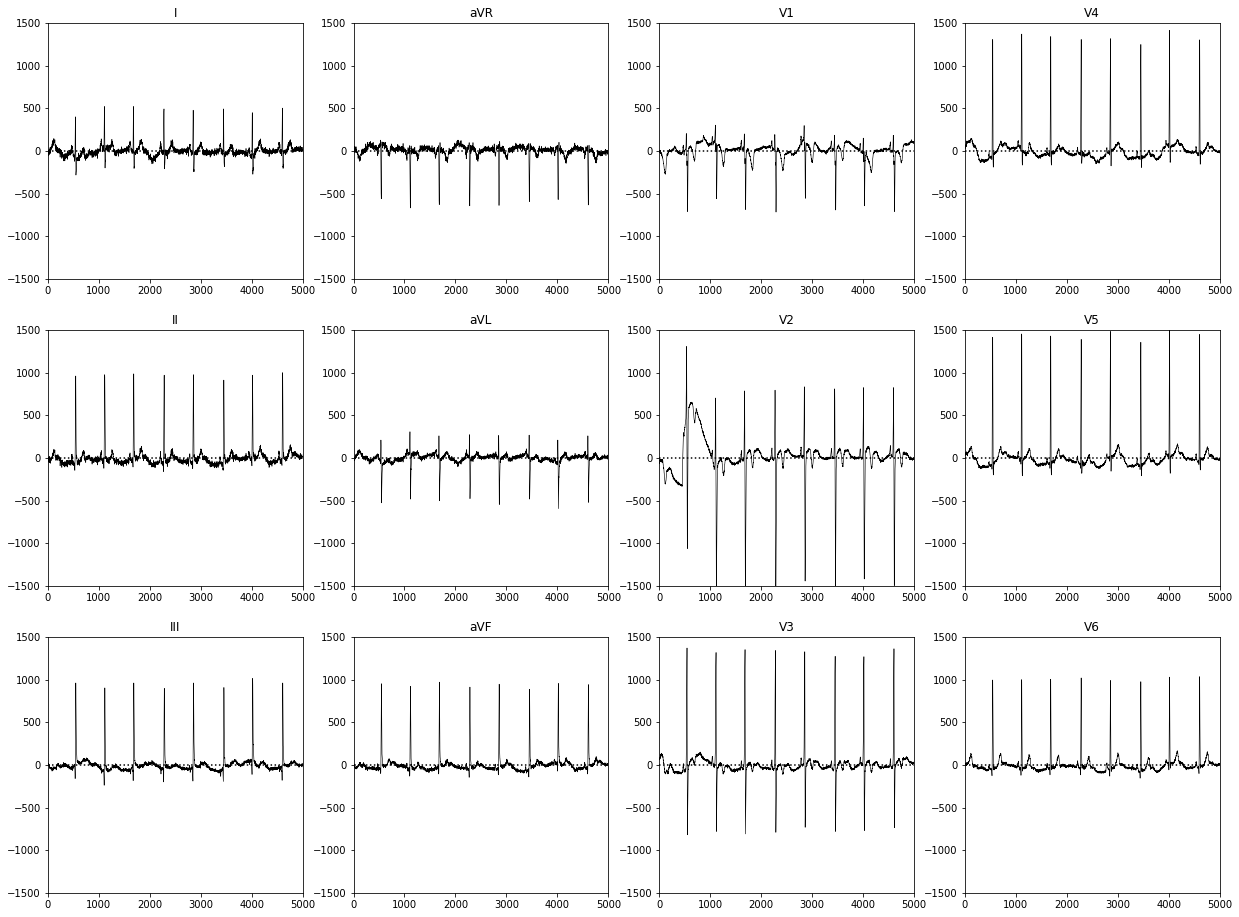

In [7]:
_lr,_lc = 3,4
_leads = [
    [['I'],['aVR'],['V1'],['V4']],
    [['II'],['aVL'],['V2'],['V5']],
    [['III'],['aVF'],['V3'],['V6']]
]


fig,ax = plt.subplots(_lr,_lc, figsize=(_lr*7,_lc*4))
#fig.set_dpi(150)
for i in range(0,3):
    for j in range(0,4):
        _key = _leads[i][j][0]
        ax[i,j].set_title(_key)
        ax[i,j].plot(ecg.signald[_key], color='black', linewidth=0.6)
        ax[i,j].set_ylim((-1500,1500))
        ax[i,j].set_xlim((0,5000))
        ax[i,j].hlines(0,0,5000,color='black',linestyle='dotted')


plt.show()

# [2.2] Plot Horizontally

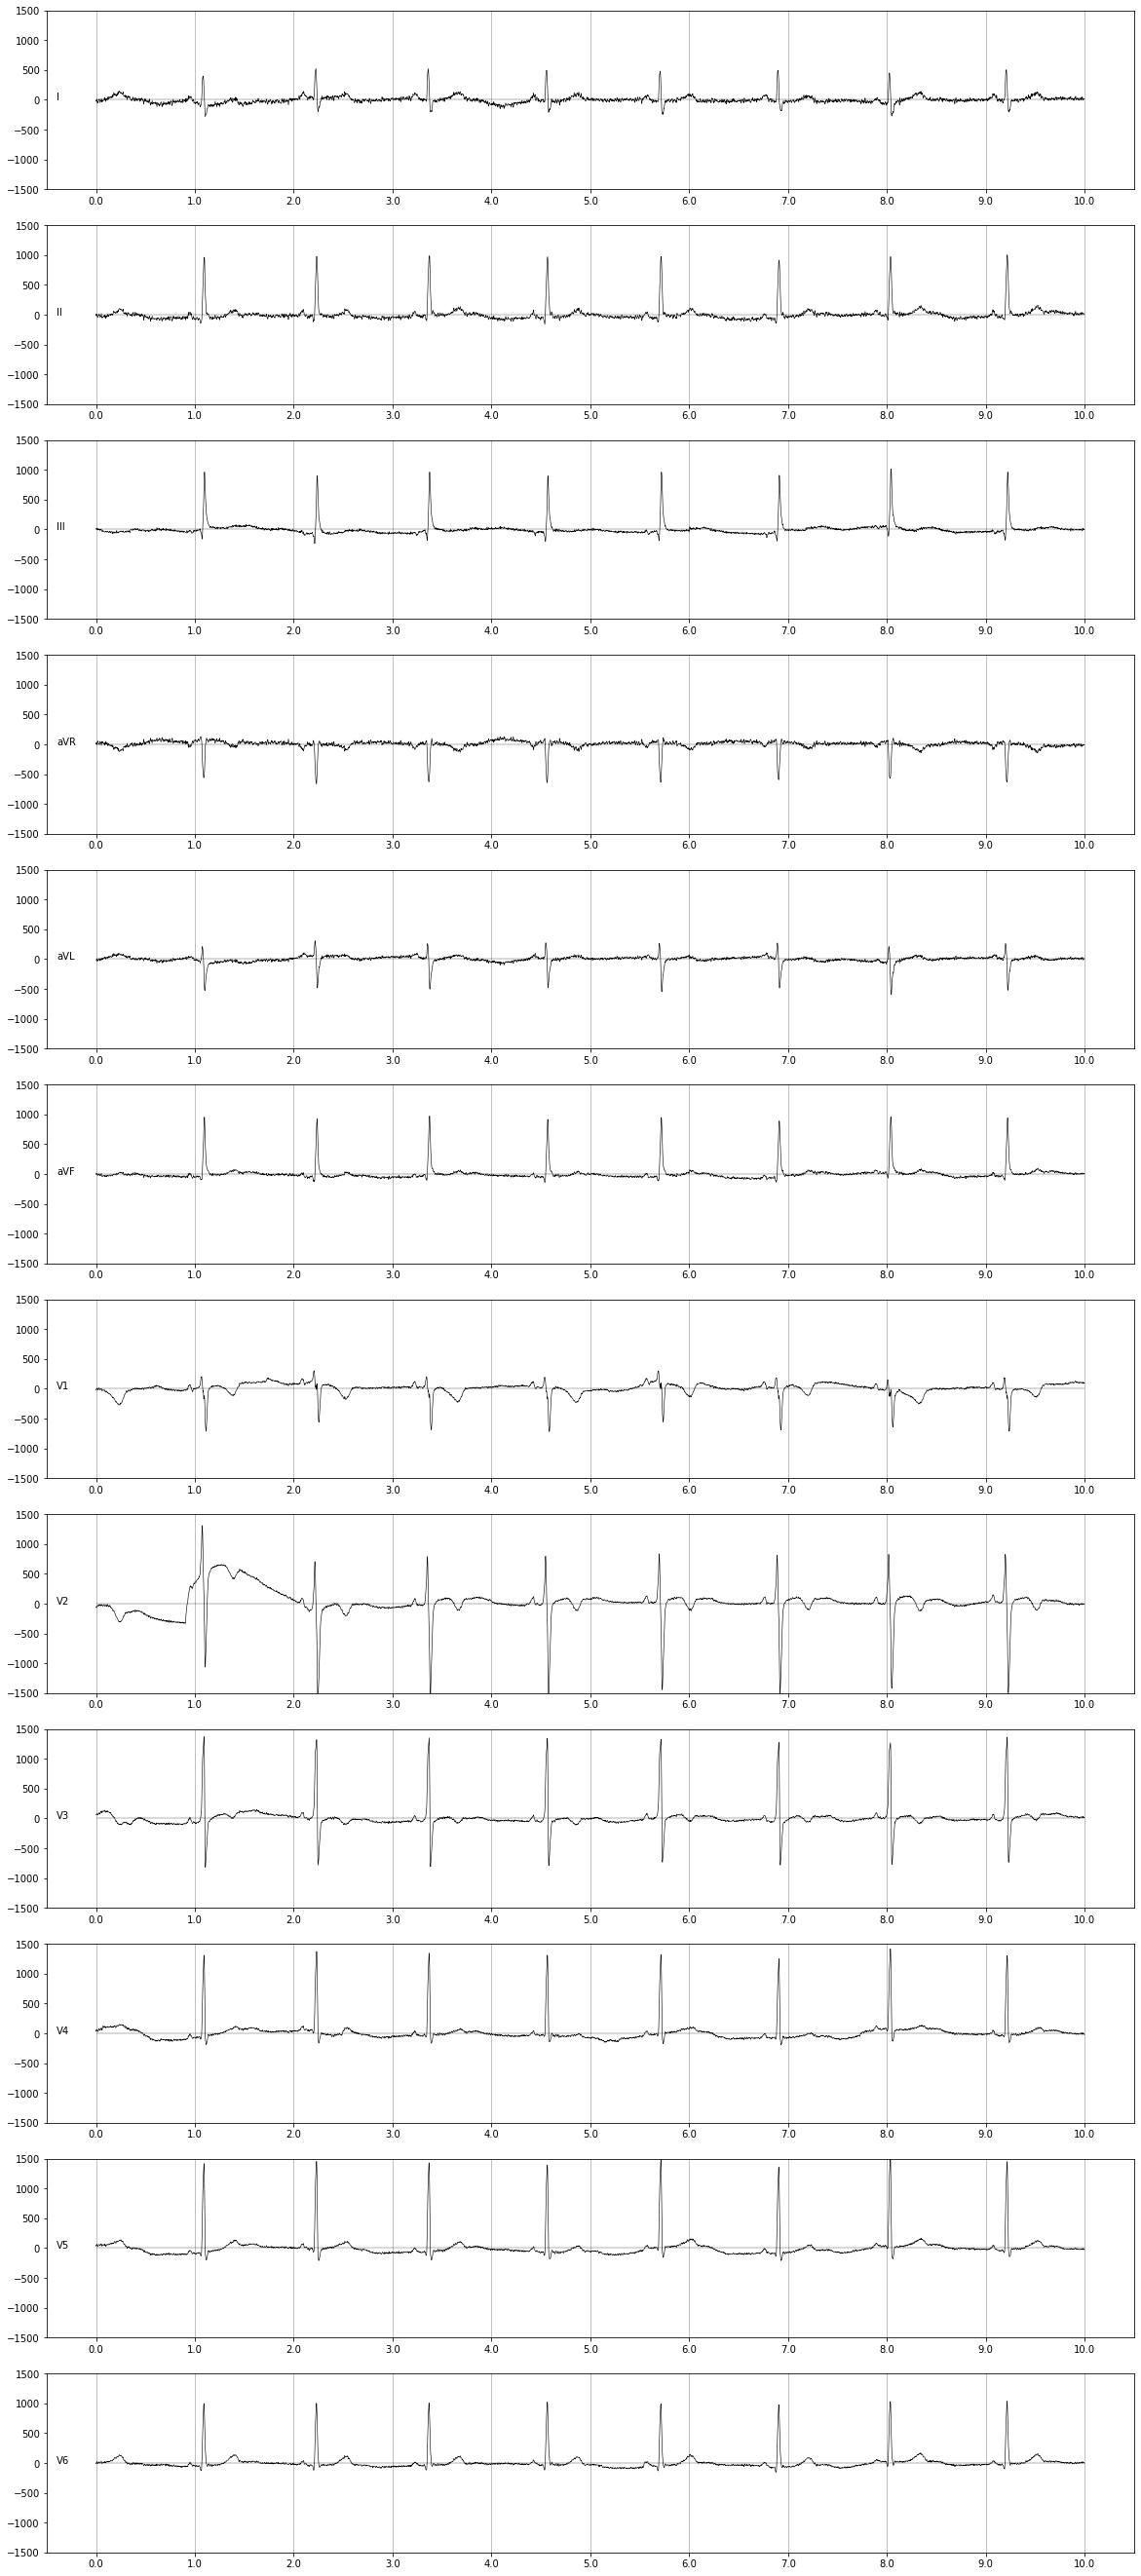

In [8]:
fig,ax = plt.subplots(12,1, figsize=(20,12*4))
#fig.set_dpi(150)
for i in range(0,12):
    _key = g_leads[i]
    #ax[i].set_title(_key)
    ax[i].plot(ecg.signald[_key], color='black', linewidth=0.6)
    ax[i].set_ylim((-1500,1500))
    ax[i].set_xticks(   np.arange(0,5001,500)  )   
    ax[i].set_xticklabels(   np.arange(0,5001,500)/BASIC_SRATE  )   
    ax[i].grid(axis='x')
    ax[i].annotate(_key,(-200,0))
    #ax[i].set_xlabel('Time(sec)')
    #ax[i].set_ylabel('mV')
    ax[i].hlines(0,0,5000,color='black', linewidth=0.3)


plt.show()

**Remarks:**

1. Data is Noisy
2. Baseline Wander Present

# Raw Signal View

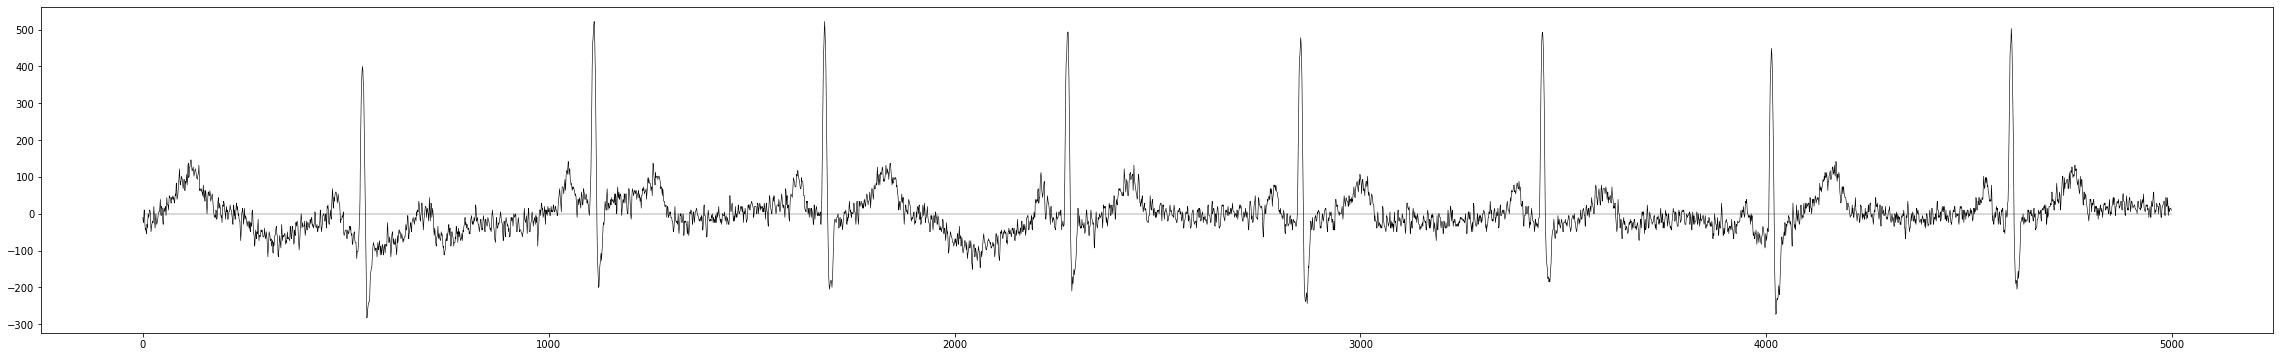

In [9]:
signal = ecg.signald['I']  #<<---- choosen Lead

plt.figure(figsize=(40,6))
plt.plot(signal, color='black', linewidth=0.6)
plt.hlines(0,0,5000,color='black', linewidth=0.3)

# Denoise

* use bior4.4 wavelet transform

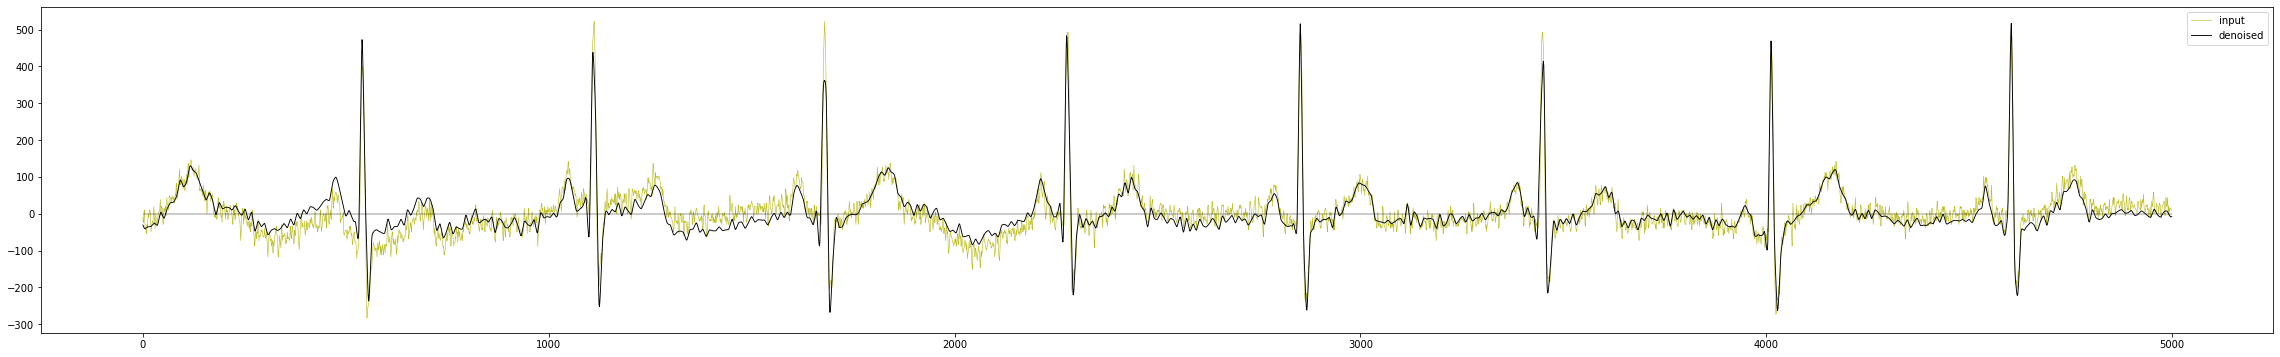

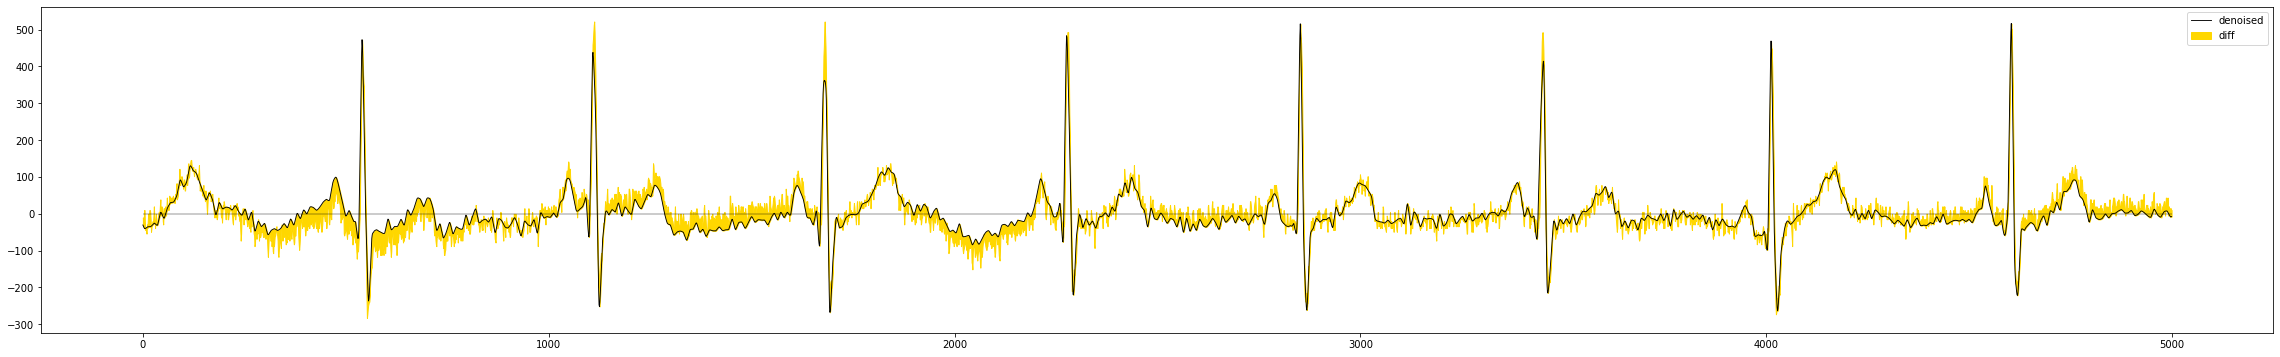

In [10]:
def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  


signal_den = denoise_signal(signal,'bior4.4', 9 , 1 , 7) #<--- trade off - the less the cutoff - the more R-peak morphology is lost
plt.figure(figsize=(40,6))

plt.plot(signal, color='tab:olive', linewidth=0.6,label = 'input')
plt.plot(signal_den, color='black', linewidth=0.9,label = 'denoised')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(signal_den, color='black', linewidth=0.9,label = 'denoised')
plt.fill_between(np.arange(0,5000,1),signal,signal_den,color='gold',label = 'diff')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

**Remarks**

* This is a fair amount of denoising without loss of peak morphology
* One may try changing the wavelet tranform arguments (dwt_transform, dlevels, cutoff_low, cutoff_high)
* Wavelet transform seems to have an effect on the baseline

# Remove Baseline Wander

* using median filtering - use 200ms filter followed by 600ms filter

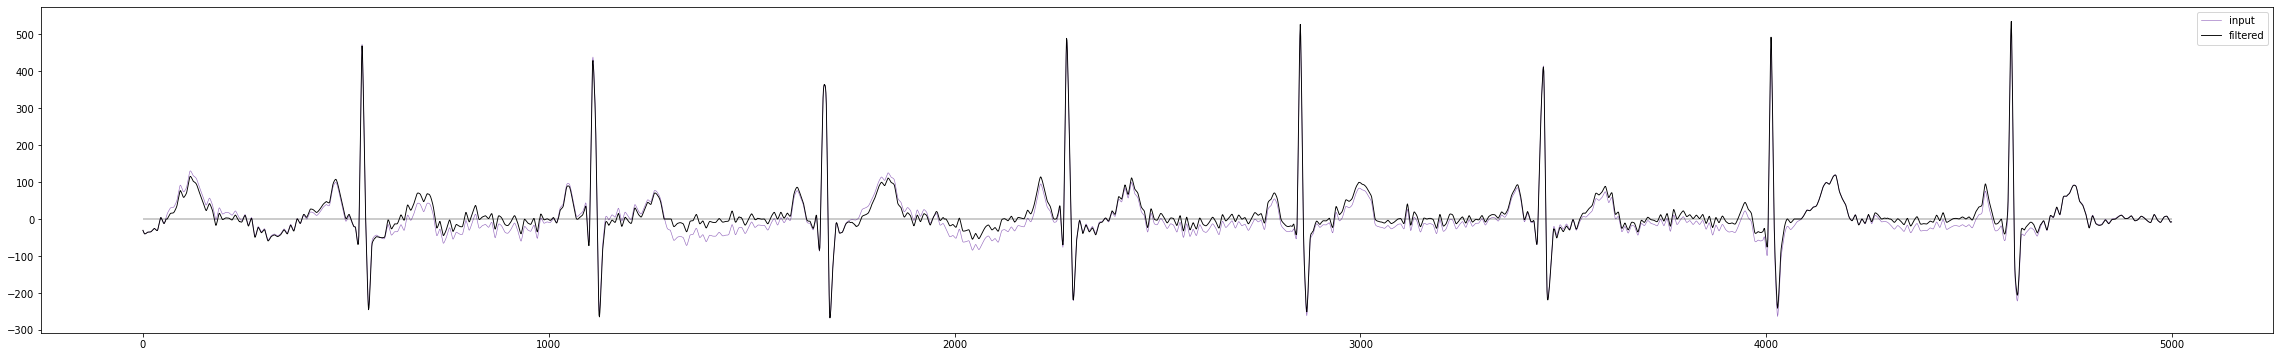

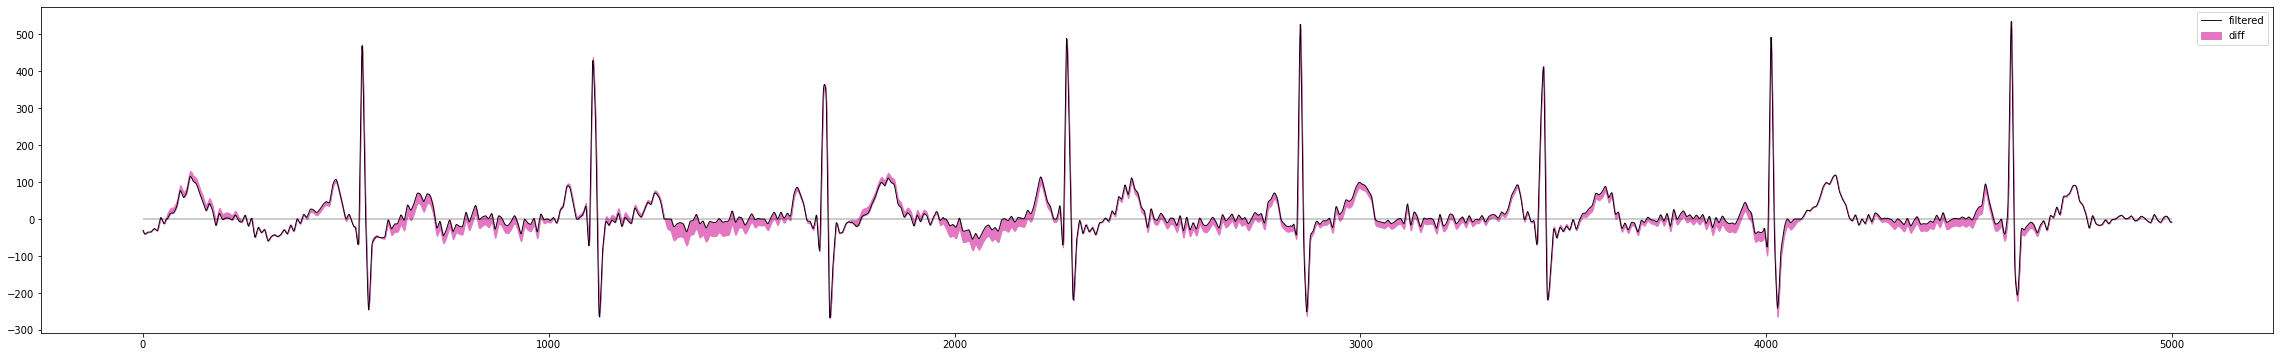

In [11]:
def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res
# baseline fitting by filtering
# === Define Filtering Params for Baseline fitting Leads======================
ms_flt_array = [0.2,0.6]    #<-- length of baseline fitting filters (in seconds)
mfa = np.zeros(len(ms_flt_array), dtype='int')
for i in range(0, len(ms_flt_array)):
    mfa[i] = get_median_filter_width(BASIC_SRATE,ms_flt_array[i])

def filter_signal(X):
    global mfa
    X0 = X  #read orignal signal
    for mi in range(0,len(mfa)):
        X0 = medfilt(X0,mfa[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0



signal_flt = filter_signal(signal_den)
plt.figure(figsize=(40,6))

plt.plot(signal_den, color='tab:purple', linewidth=0.6,label = 'input')
plt.plot(signal_flt, color='black', linewidth=0.9,label = 'filtered')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(signal_flt, color='black', linewidth=0.9,label = 'filtered')
plt.fill_between(np.arange(0,5000,1),signal_den,signal_flt,color='tab:pink',label = 'diff')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

**Remarks**

* Baseline seems to be fitted fairly
* we first denoised the signal and then fitted the baseline

# Which one to do first - Denoise or Fit baseline ?

* Does it make a difference?

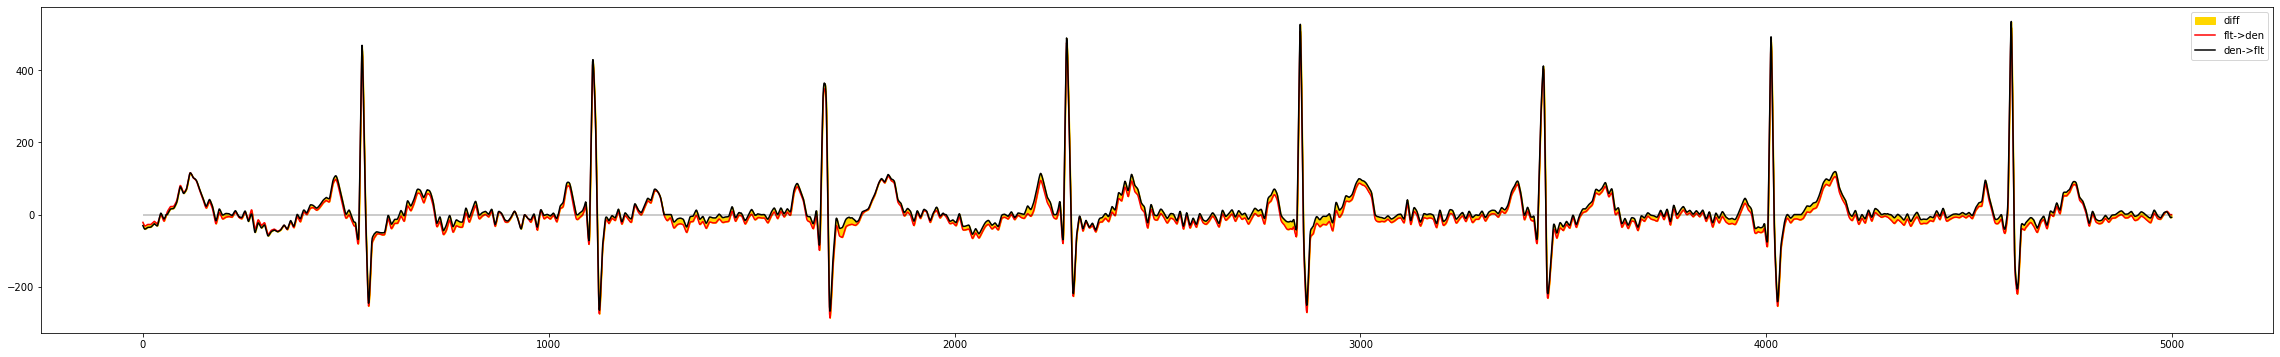

In [12]:
s1 = denoise_signal(filter_signal(signal),'bior4.4', 9 , 1 , 7) # first filtered then denoised
s2 = filter_signal(denoise_signal(signal,'bior4.4', 9 , 1 , 7)) #first denoised then filtered

plt.figure(figsize=(40,6))

#plt.plot(signal, color='black', linewidth=0.4,label = 'input')
plt.fill_between(np.arange(0,5000,1),s1,s2,color='gold',label = 'diff')
plt.plot(s1, color='red',label = 'flt->den')
plt.plot(s2, color='black',label = 'den->flt')
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.legend()
plt.show()

**Remarks**

* Denoising first and then fitting the baseline seems to work better

# R-Peak Detection

* https://pypi.org/project/py-ecg-detectors/

In [13]:
from ecgdetectors import Detectors # use pip install py-ecg-detectors
detectors = Detectors(BASIC_SRATE)

# Detect R-Peaks

* using known algorithms

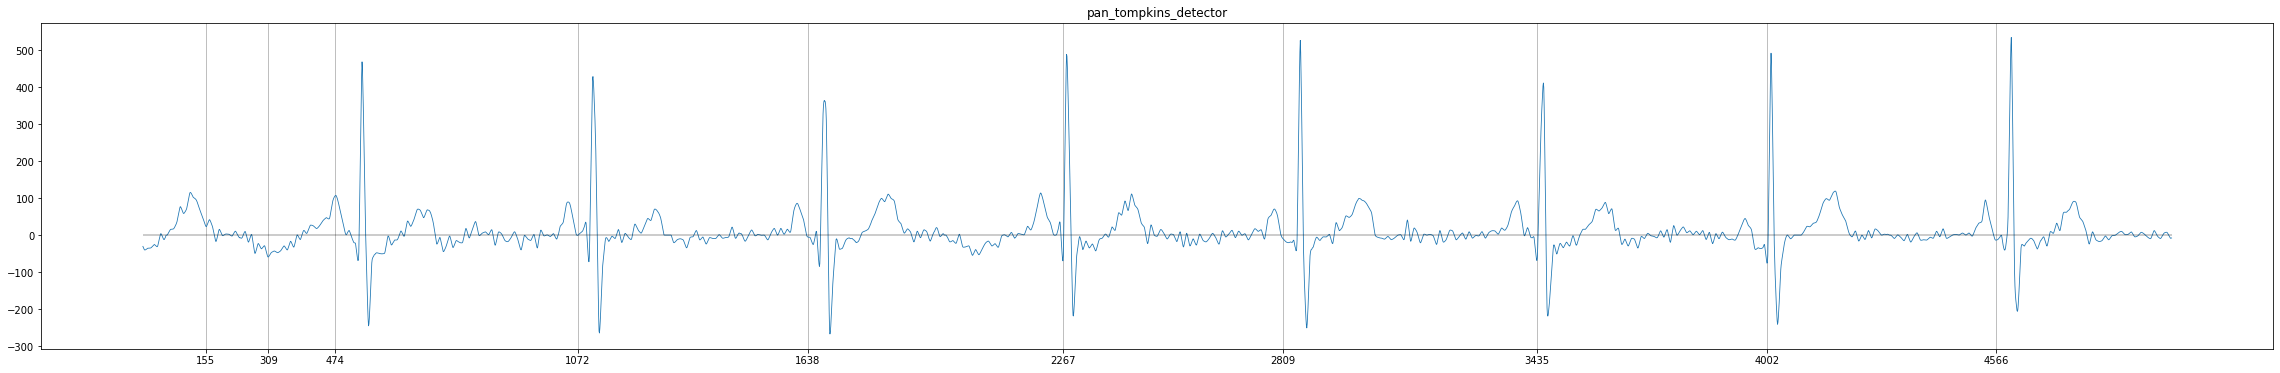

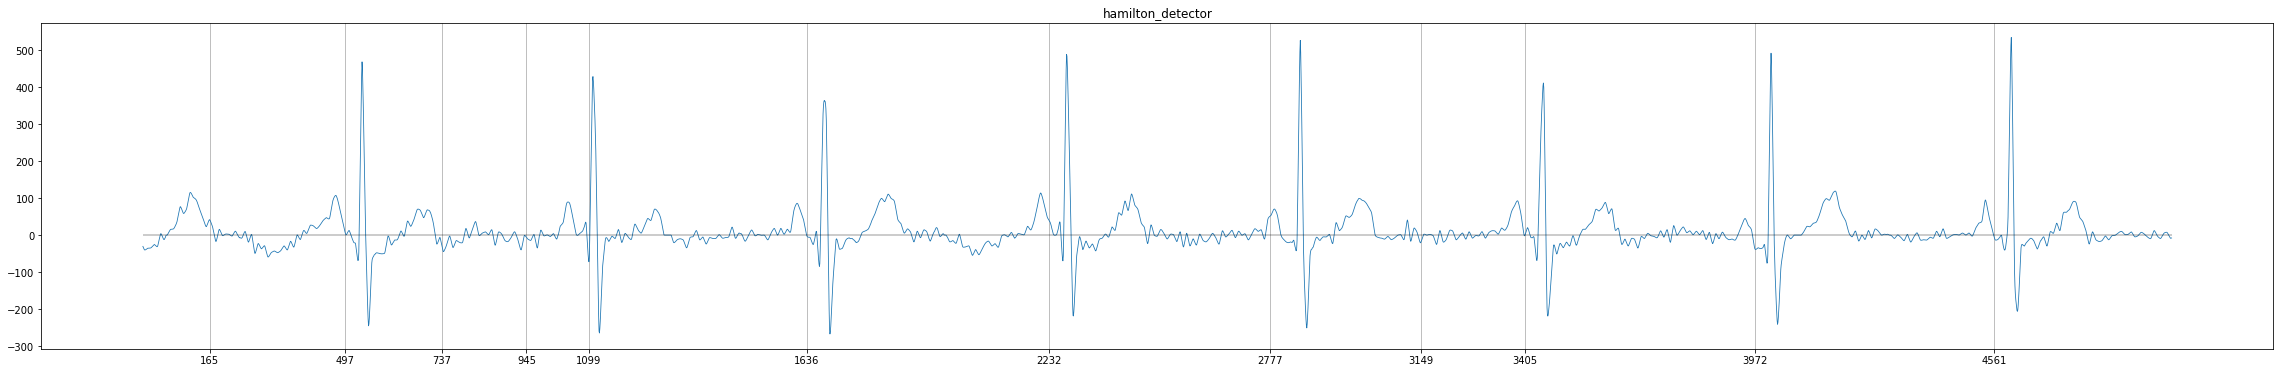

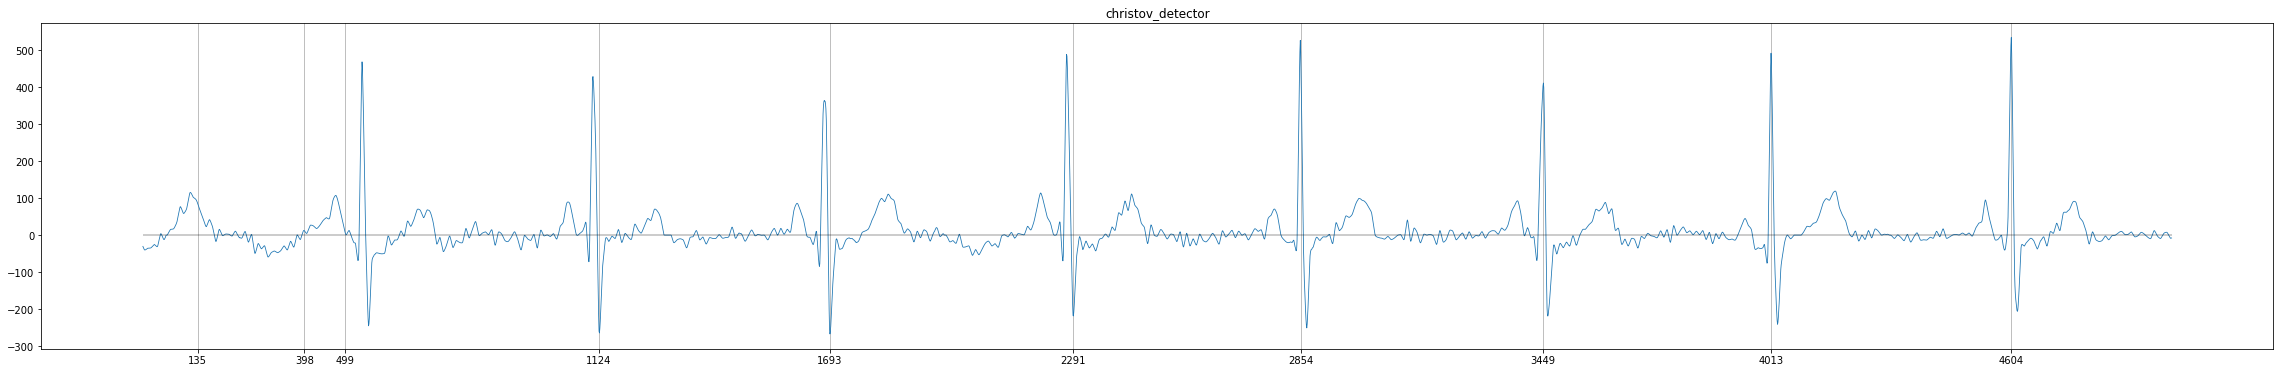

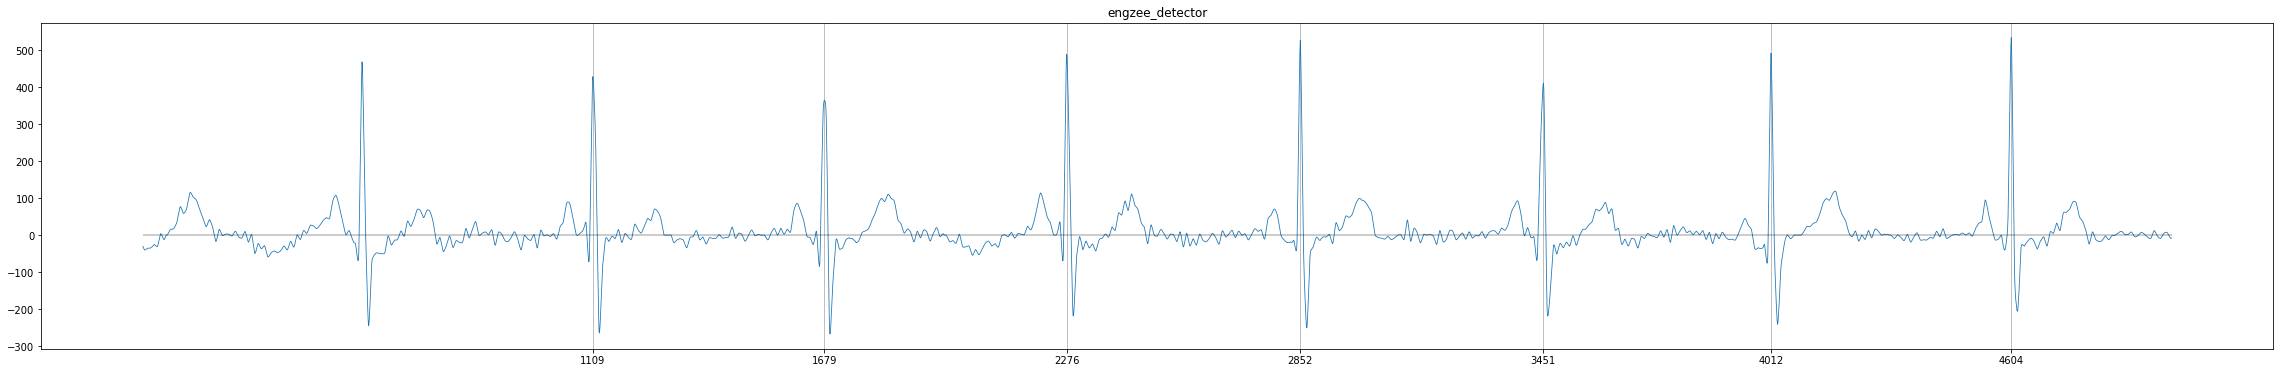

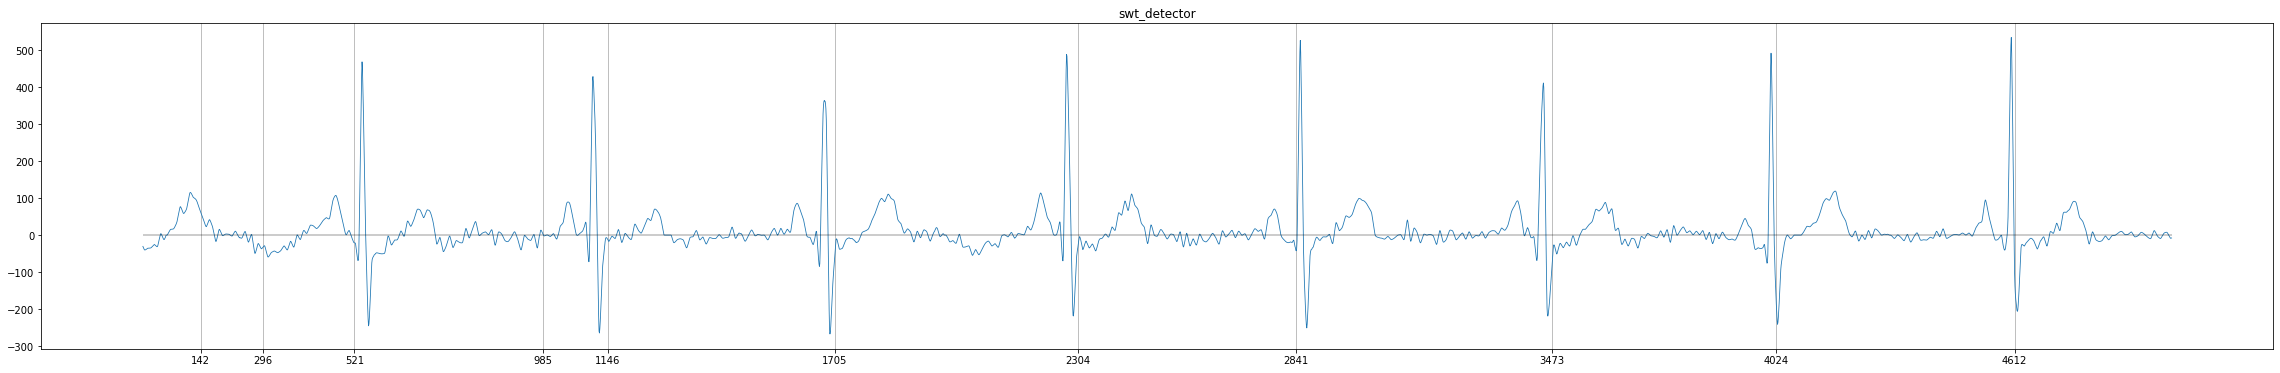

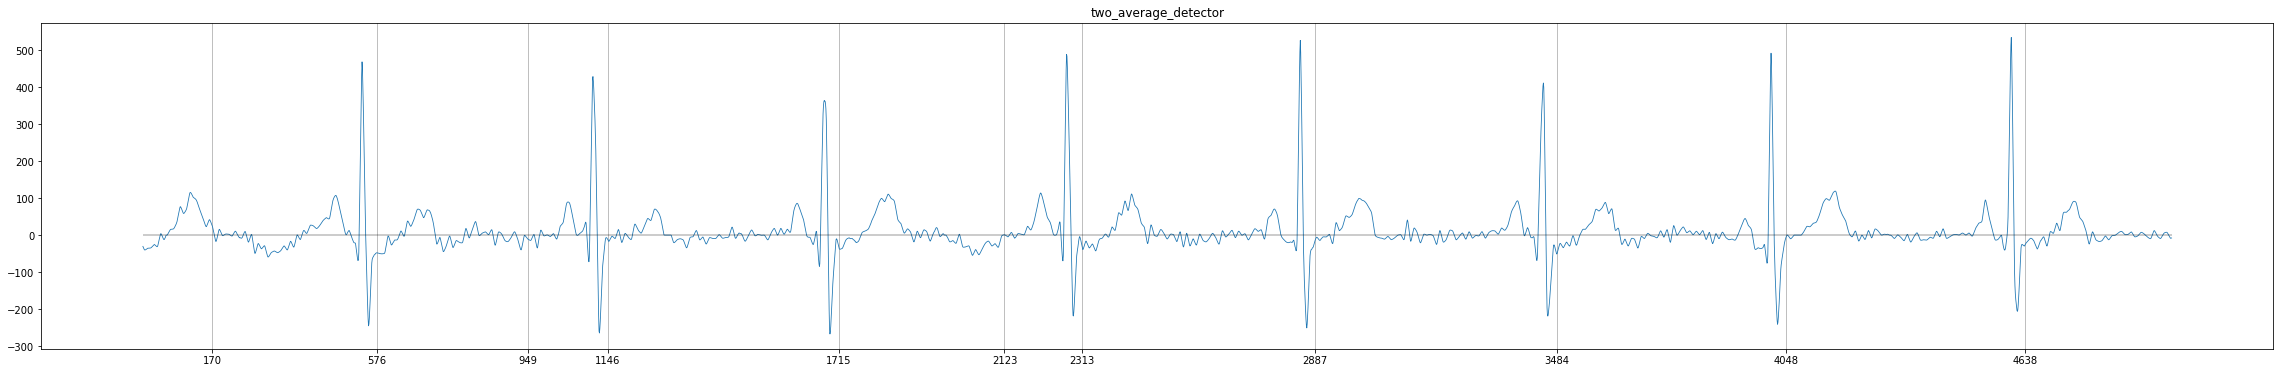

In [14]:
signal_pad_samples = 10
signal_pad = np.zeros(signal_pad_samples) # pad one sec to detect initial peaks properly
signalf = signal_flt
detectors = Detectors(BASIC_SRATE)

detectors = {
            'pan_tompkins_detector':[detectors.pan_tompkins_detector, []],
            'hamilton_detector':[detectors.hamilton_detector, []],
            'christov_detector':[detectors.christov_detector, []],
            'engzee_detector':[detectors.engzee_detector, []],
            'swt_detector':[detectors.swt_detector, []],
            'two_average_detector':[detectors.two_average_detector, []],
            }


for kd in detectors.keys():
    vd = detectors[kd]
    r_peaks = np.array(vd[0](np.hstack((signal_pad,signal_flt)))) - signal_pad_samples
    vd[1] = r_peaks
    plt.figure(figsize=(40,6))
    plt.title(kd)
    plt.plot(signalf,color='tab:blue',linewidth=0.8)
    plt.hlines(0,0,5000,color='black', linewidth=0.4)
    plt.xticks(r_peaks)
    plt.grid(axis='x')
    plt.show()




**Remarks**

* **christov_detector** seems to work the best for most cases
* results vary for different leads and patients

# Final Data

In [15]:
print(detectors.keys())

dict_keys(['pan_tompkins_detector', 'hamilton_detector', 'christov_detector', 'engzee_detector', 'swt_detector', 'two_average_detector'])


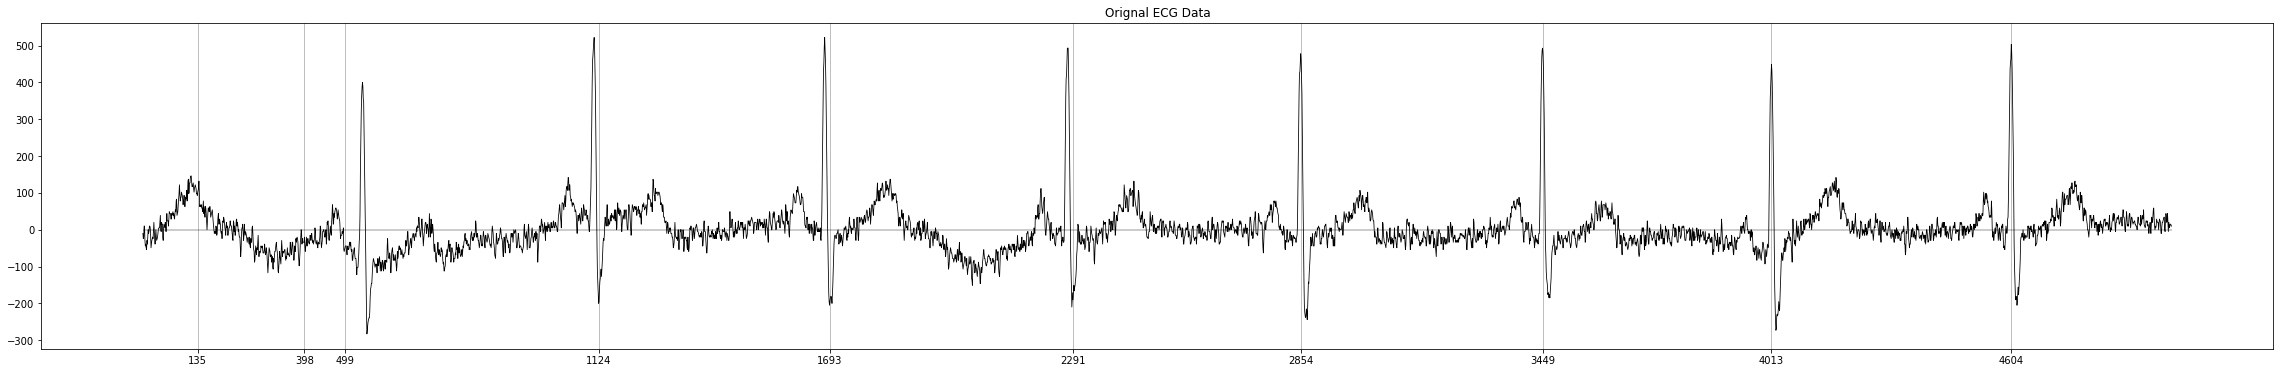

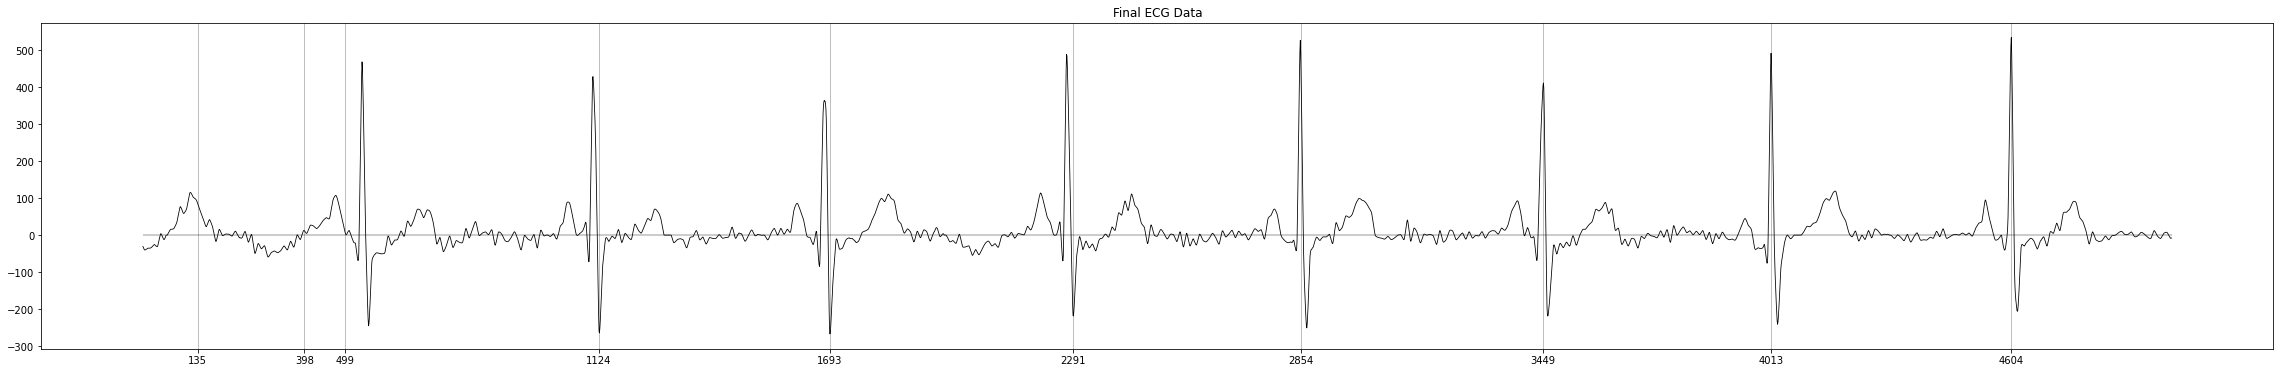

In [16]:
data_signal = signalf
data_peaks = detectors['christov_detector'][1]

plt.figure(figsize=(40,6))
plt.title('Orignal ECG Data')
plt.plot(signal,color='black',linewidth=0.8)
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.xticks(data_peaks)
plt.grid(axis='x')
plt.show()

plt.figure(figsize=(40,6))
plt.title('Final ECG Data')
plt.plot(data_signal,color='black',linewidth=0.8)
plt.hlines(0,0,5000,color='black', linewidth=0.4)
plt.xticks(data_peaks)
plt.grid(axis='x')
plt.show()



**Concluding Remarks**

**Steps of ECG Preprocessing**
 * Denoising - Denoised ECG using bior4.4 wavelet transform - there is a trade off between 'cutoff' limits and preservation of wave morphology
 * Baseline Wander - Fitted baseline using Median Filters of 200ms and 600ms - fitting baseline after denoising seems to work better
 * Peak Detection - Tried various known R-peak detection algorithms - christov_detector seem to work best for most records
 
 
*TODO*
 * Beats are not labeled, try testing with previous models and assert the results manually 

# The End